![FMD_Overview](https://github.com/edkreuk/FMD_FRAMEWORK/blob/main/Images/FMD_Overview.png?raw=true)

In [38]:
%pip install ms-fabric-cli pillow cairosvg --quiet

Note: you may need to restart the kernel to use updated packages.


In [39]:
import subprocess
import os
from time import sleep, time
import json
import shutil
import re
import requests
import zipfile
import yaml
import struct
import pyodbc
import notebookutils
import sempy.fabric as fabric
import cairosvg
import base64
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw, ImageFont
from requests.adapters import HTTPAdapter, Retry
from io import BytesIO
from zipfile import ZipFile 

# Configuration and Parameters

**Fabric Administrator Role is required to create domain**

In [40]:
FrameworkName= 'DEMO'                               # max 6 characters for better visibility, no spaces and the end of the name

assign_icons = True                                 # Set to True to assign default icons to workspaces; set to False if you have already assigned custom icons

load_demo_data= True                                # Set to True if you want to load the demo data, otherwise set to False
lakehouse_schema_enabled = True                     # Set to True if you want to use the lakehouse schema, otherwise set to False

driver = '{ODBC Driver 18 for SQL Server}' # Change this if you use a different driver


## Capacity settings

In [41]:
capacity_name_dvlm = "Trial-Erwin"                  # Which capacity will be used for these workspaces in development
capacity_name_prod = 'Trial-Erwin'                  # Which capacity will be used for these workspaces in production
capacity_name_config = 'Trial-Erwin'                # Which capacity will be used for this workspace for the Metadata Database

## Domain settings

In [42]:
create_domains=  True                               # If you do not have a Fabric Admin role, you need to set this option to False. For domain creation the Fabric Admin role is needed

domain_name='FMD'                                   # Main Domain
sub_domain_names= ['FINANCE','SALES']               # Create business domains(sub)

domain_contributor_role = {"type": "Contributors","principals": [{"id": "86897900-8de5-4894-ae41-1b4d1642acda","type": "Group"}  ]}  # Which group(Object ID) can add or remove workspaces to this domain



## Workspace Roles settings

In [43]:
workspace_roles_code = [ # Keep emtpy [] if you only want to assign this to your personal account
                                        {
                       "principal": {
                            "id": '86897900-8de5-4894-ae41-1b4d1642acda',
                            "type": "Group"
                        },
                        "role": "admin"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        },
                        {
                       "principal": {
                            "id": 'b0bf9847-5b7a-4560-947b-b149f71d303b',
                            "type": "ServicePrincipal"
                        },
                        "role": "contributor"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        }
                    ]
workspace_roles_data =  [ # Keep emtpy [] if you only want to assign this to your personal account
                                        {
                       "principal": {
                            "id": '86897900-8de5-4894-ae41-1b4d1642acda',
                            "type": "Group"
                        },
                        "role": "admin"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        },    
                         {
                       "principal": {
                            "id": '5c906b5c-d1d7-4984-b047-adacd8d795fe',
                            "type": "Group"
                        },
                        "role": "contributor"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        },
                        {
                       "principal": {
                            "id": 'b0bf9847-5b7a-4560-947b-b149f71d303b',
                            "type": "ServicePrincipal"
                        },
                        "role": "contributor"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        }
                    ]
workspace_roles_data_gold = [ # Keep emtpy [] if you only want to assign this to your personal account
                    {
                      "principal": {
                            "id": '86897900-8de5-4894-ae41-1b4d1642acda',
                             "type": "Group"
                        },
                        "role": "admin"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        }
                    ]

workspace_roles_code_gold = [ # Keep emtpy [] if you only want to assign this to your personal account
                    {
                      "principal": {
                            "id": '86897900-8de5-4894-ae41-1b4d1642acda',
                             "type": "Group"
                        },
                        "role": "admin"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        }
                    ]

workspace_roles_reporting = [ # Keep emtpy [] if you only want to assign this to your personal account
                    {
                        "principal": {
                            "id": '86897900-8de5-4894-ae41-1b4d1642acda',
                            "type": "Group"
                        },
                        "role": "admin"  #(choose from 'admin', 'member', 'contributor', 'viewer')
                        }
                    ]

## Configuration settings  (Fabric Database)


In [44]:
configuration = {
                    'workspace': {
                        'name' : FrameworkName + ' CONFIG FMD',             # Name of target workspace
                        'roles' : workspace_roles_data,                     # Roles to assign to the workspace
                        'capacity_name' : capacity_name_config              # Name of target capacity for the configuration workspace
                    },
                       'DatabaseName' : 'SQL_'+FrameworkName+'_FRAMEWORK'   # Name of target configuration SQL Database
}

## Workspace configuration

In [45]:

##### DO NOT CHANGE UNLESS SPECIFIED OTHERWISE, FE ADDING NEW ENVIRONMENTS ####
environments = [
                    {
                        'environment_name' : 'development',                 # Name of target environment
                        'workspaces': {
                            'data' : {
                                'name' : FrameworkName + ' DATA (D) FMD',   # Name of target code workspace for development
                                'roles' : workspace_roles_data,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_dvlm        # Name of target data workspace for development
                            },
                            'code' : {
                                'name' : FrameworkName + ' CODE (D) FMD',   # Name of target data workspace for development
                                'roles' : workspace_roles_code,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_dvlm        # Name of target code workspace for development
                            },
                        },
                        'connections' : {
                            'CON_FMD_FABRIC_SQL' : '372237f9-709a-48f8-8fb2-ce06940c990e',          # Required Guid to the Fabric SQL connection
                            'CON_FMD_FABRIC_PIPELINES' : '6d8146c6-a438-47df-94e2-540c552eb6d7',    # Required Guid to the Fabric datapipelines connection
                            'CON_FMD_ADF_PIPELINES' : '02e107b8-e97e-4b00-a28c-668cf9ce3d9a'        # 10000000-0000-0000-0000-000000000000'

                        }
                    },
                    {
                        'environment_name' : 'production',                  # Name of target environment
                        'workspaces': {
                            'data' : {
                                'name' : FrameworkName + ' DATA (P) FMD',   # Name of target data workspace for production
                                'roles' : workspace_roles_data,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_prod        # Name of target data workspace for production   
                            },
                            'code' : {
                                'name' : FrameworkName + ' CODE (P) FMD',   # Name of target code workspace for production
                                'roles' : workspace_roles_code,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_prod        # Name of target code workspace for production
                            },                            
                        },
                        'connections' : {
                            'CON_FMD_FABRIC_SQL' : '372237f9-709a-48f8-8fb2-ce06940c990e',          # Required Guid to the Fabric SQL connection
                            'CON_FMD_FABRIC_PIPELINES' : '6d8146c6-a438-47df-94e2-540c552eb6d7',    # Required Guid to the Fabric datapipelines connection
                            'CON_FMD_ADF_PIPELINES' : '02e107b8-e97e-4b00-a28c-668cf9ce3d9a'        # 10000000-0000-0000-0000-000000000000'

                        }
                    }
                ]
###################################################

## Domain Configuration

In [46]:
##### DO NOT CHANGE UNLESS SPECIFIED OTHERWISE, FE ADDING NEW ENVIRONMENTS ####
domain_deployment = [
                    {
                        'environment_name' : 'development',                 # Name of target environment
                        'environment_short' : 'D',                          # Short of target environment
                        'workspaces': {
                         
                            'data' : {
                                'roles' : workspace_roles_data_gold,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_dvlm        # Name of target data workspace for development
                            },
                            'code' : {
                                'roles' : workspace_roles_code_gold,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_dvlm        # Name of target code workspace for development
                            },
                            'reporting' : {
                            'roles' : workspace_roles_reporting,       # Roles to assign to the workspace
                            'capacity_name' : capacity_name_dvlm        # Name of target code workspace for development
                            }
                        }
                    },
                    {
                        'environment_name' : 'production',                  # Name of target environment
                        'environment_short' : 'P',                          # Short of target environment
                        'workspaces': {
                         
                            'data' : {
                                'roles' : workspace_roles_data_gold,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_prod        # Name of target data workspace for development
                            },
                            'code' : {
                                'roles' : workspace_roles_code_gold,             # Roles to assign to the workspace
                                'capacity_name' : capacity_name_prod        # Name of target code workspace for development
                            },
                            'reporting' : {
                                'roles' : workspace_roles_reporting,        # Roles to assign to the workspace
                                'capacity_name' : capacity_name_prod        # Name of target code workspace for development
                            }
                        }
                    }
                ]
###################################################

## Icon settings

In [47]:
# Workspace icon definition. Setting the icons to None will delete the existing icon of the workspaces specified.

workspace_icon_def = {
    "icons": {
        "code": "fmd_code_icon.png",
        "data": "fmd_data_icon.png",
        "config": "fmd_config_icon.png",
        "reporting": "fmd_reporting_icon.png",
        "gold": "fmd_gold_icon.png"
    }
}

# Repo Configuration

In [48]:
#FMD Framework code
##### DO NOT CHANGE UNLESS SPECIFIED OTHERWISE ####
repo_owner = "edkreuk"              # Owner of the repository
repo_name = "FMD_FRAMEWORK"         # Name of the repository
branch = "main"                     #"main" is default                    
folder_prefix = ""
###################################################


## Download source & config files

In [49]:
def download_folders_as_zip(repo_owner, repo_name, output_zip, branch="main", folders_to_extract=None, remove_folder_prefix=""):
    if folders_to_extract is None:
        folders_to_extract = []

    # Construct the URL for the GitHub API to download the repository as a zip file
    url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/zipball/{branch}"
    response = requests.get(url)
    response.raise_for_status()

    # Ensure the directory for the output zip file exists
    os.makedirs(os.path.dirname(output_zip), exist_ok=True)

    # Create a zip file in memory from GitHub response
    with zipfile.ZipFile(BytesIO(response.content)) as zipf:
        # Open output zip in append mode
        with zipfile.ZipFile(output_zip, 'a') as output_zipf:
            for file_info in zipf.infolist():
                for folder in folders_to_extract:
                    folder_path = f"/{folder}" if not folder.startswith("/") else folder
                    if re.sub(r'^.*?/', '/', file_info.filename).startswith(folder_path):
                        file_data = zipf.read(file_info.filename)
                        parts = file_info.filename.split('/')
                        if remove_folder_prefix:
                            parts = [p for p in parts if p != remove_folder_prefix]
                        output_zipf.writestr('/'.join(parts[1:]), file_data)

def uncompress_zip_to_folder(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)

# ✅ Combine all folders into one zip
download_folders_as_zip(repo_owner, repo_name, output_zip = "./builtin/src/src.zip", branch = branch, folders_to_extract= [f"{folder_prefix}/src"] , remove_folder_prefix = f"{folder_prefix}")
download_folders_as_zip(repo_owner, repo_name, output_zip = "./builtin/config/config.zip", branch = branch, folders_to_extract= [f"{folder_prefix}/config"] , remove_folder_prefix = f"{folder_prefix}")
# ✅ Uncompress everything into ./builtin
uncompress_zip_to_folder(zip_path = "./builtin/config/config.zip", extract_to= "./builtin")

 

/home/trusted-service-user/jupyter-env/python3.11/lib/python3.11/zipfile.py:1567: UserWarning: Duplicate name: 'src/'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/trusted-service-user/jupyter-env/python3.11/lib/python3.11/zipfile.py:1567: UserWarning: Duplicate name: 'src/ENV_FMD.Environment/'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/trusted-service-user/jupyter-env/python3.11/lib/python3.11/zipfile.py:1567: UserWarning: Duplicate name: 'src/ENV_FMD.Environment/.platform'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/trusted-service-user/jupyter-env/python3.11/lib/python3.11/zipfile.py:1567: UserWarning: Duplicate name: 'src/ENV_FMD.Environment/Setting/'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/trusted-service-user/jupyter-env/python3.11/lib/python3.11/zipfile.py:1567: UserWarning: Duplicate name: 'src/ENV_FMD.Environment/Setting/Sparkcompute.yml'
  return self._open_to_write(zinfo, force_zip

# CLI Login

In [50]:
# Set environment parameters for Fabric CLI
token = notebookutils.credentials.getToken('pbi')
os.environ['FAB_TOKEN'] = token
os.environ['FAB_TOKEN_ONELAKE'] = token

tasks=[]


## Get existing connections

In [51]:
result = subprocess.run(["fab", "api", "-X", "get", "connections"], capture_output=True, text=True)
connections=json.loads(result.stdout)["text"]
connection_list = [item['id'] for item in connections['value']]

# Deployment functions

In [52]:
# -------------------------------
# FABRIC CLI Utilities
# -------------------------------

def run_fab_command(command, capture_output=False, silently_continue=False, raw_output=False):
    """
    Executes a Fabric CLI command with optional output capture and error handling.
    """
    result = subprocess.run(["fab", "-c", command], capture_output=capture_output, text=True)
    if not silently_continue and (result.returncode > 0 or result.stderr):
        raise Exception(f"Error running fab command. exit_code: '{result.returncode}'; stderr: '{result}'")
    if capture_output:
        return result if raw_output else result.stdout.strip()
    return None

def get_cluster_url():
    """
    Get the Fabric Cluster.
    """
    response = run_fab_command(f"api -A powerbi groups", capture_output=True, silently_continue=True)
    # Parse the JSON response
    response_json = json.loads(response)["text"]
    # Extract the @odata.context URL
    odata_context = response_json.get("@odata.context", "")
    # Use re.search instead of re.match
    match = re.search(r"(https://[^/]+/)", odata_context)
    if match:
        return match.group(1)
    else:
        print("Cluster URL not found.")
        return None
    
# -------------------------------
# Domain Management
# -------------------------------
def create_fabric_domain(domain_name):
    """
    Create a domain.
    """
    start = time()


    try:
        run_fab_command(f'create .domains/{domain_name}.Domain',  capture_output=True, silently_continue=True)
        print(f"✅ {domain_name} Created'")
    except Exception as e:
        print(f" ❌ Failed to create domain: {e}")
    assign_domain_description(domain_name)
    assign_domain_contributor_roles(domain_contributor_role, domain_name)
    tasks.append({"task_name": f"Create or Update Domain {domain_name}","task_duration": int(time() - start),"status": "success"})

def create_fabric_sub_domain(domain_name, sub_domain):
    """
    Create a sub domain in a domain.
    """
    start = time()
    
    try:
        run_fab_command(f'create .domains/{sub_domain}.Domain -P parentDomainName={domain_name}',  capture_output=True, silently_continue=True)
        print(f"✅ {sub_domain} created and assigned to '{domain_name}'")
    except Exception as e:
        print(f" ❌ Failed to create sub domain: {e}")
    assign_domain_description(domain_name)
    tasks.append({"task_name": f"Create or update Sub Domain {sub_domain}","task_duration": int(time() - start),"status": "success"})

def assign_fabric_domain(domain_name, workspace_name):
    """
    Assigns a domain to the workspace.
    """
    try:
        run_fab_command(f'assign .domains/{domain_name}.Domain -W {workspace_name}.Workspace -f',  capture_output=True, silently_continue=True)
        print(f"✅ {domain_name} domain assigned to '{workspace_name}'")
    except Exception as e:
        print(f" ❌ Failed to assign domain: {e}")

def assign_domain_description(domain_name):
    """
    Assigns a standard description to an Domain.
    """
    payload = 'Note: This Domain  was initially generated by the FMD Framework. For further details, please refer to the documentation at https://github.com/edkreuk/FMD_FRAMEWORK.'
    try:
        run_fab_command(f'set .domains/{domain_name}.Domain -q description -i {payload} -f', silently_continue=True)
        print(f"✅ Description applied to {domain_name} ")
    except Exception as e:
        print(f" ❌ Failed to assign description: {e}")

def assign_domain_contributor_roles(domain_contributor_role,domain_name):
    """
    Assigns the Contributor role to a domain for a specific security group.
    """
    payload = 'SpecificUsersAndGroups'
    run_fab_command(f'set .domains/{domain_name}.Domain -q contributorsScope -i {payload} -f', capture_output=True,silently_continue=True)
    domain_id = get_domain_id_by_name(domain_name)
    payload_role = json.dumps(domain_contributor_role)
    try:
        run_fab_command(f'api -X post admin/domains/{domain_id}/roleAssignments/bulkAssign -i "{payload_role}"',capture_output=True ,silently_continue=True  )
        print(f"✅ Contributor role applied to domain: {domain_name}")
    except Exception as e:
        print(f" ❌ Failed to apply role: {e}")



def get_domain_id_by_name(domain_name):
    """
    Retrieves the domain ID by its display name.
    """
    result = run_fab_command("api -X get domains/", capture_output=True, silently_continue=True)
    domains = json.loads(result)["text"]["value"]
    normalized_name = domain_name.strip().lower()
    match = next((w for w in domains if w['displayName'].strip().lower() == normalized_name), None)
    return match['id'] if match else None
# -------------------------------
# Workspace Management
# -------------------------------

def get_workspace_id_by_name(workspace_name):
    """
    Retrieves the workspace ID by its display name.
    """
    result = run_fab_command("api -X get workspaces/", capture_output=True, silently_continue=True)
    workspaces = json.loads(result)["text"]["value"]
    normalized_name = workspace_name.strip().lower()
    match = next((w for w in workspaces if w['displayName'].strip().lower() == normalized_name), None)
    return match['id'] if match else None

def ensure_workspace_exists(workspace, workspace_name):
    """
    Ensures the workspace exists; creates it if not found.
    """
    workspace_id = get_workspace_id_by_name(workspace_name)
    if workspace_id:
        print(f" - Workspace '{workspace_name}' found. Workspace ID: {workspace_id}- assign capacity: {workspace['capacity_name']}")
        try:
            run_fab_command(f'assign ".capacities/{workspace["capacity_name"]}.Capacity" -W "{workspace_name}.Workspace" -f', silently_continue=True)
            print(f" ✅ assign capacity: {workspace['capacity_name']}")
            return workspace_id, "exists"
        except Exception as e:
            print(f" ❌ Failed to assign capacity: {e}")

    print(f" - Workspace '{workspace_name}' not found. Creating new workspace...")
    try:
        run_fab_command(f'mkdir "{workspace_name}.workspace" -P capacityName="{workspace["capacity_name"]}"', silently_continue=True)
        print(f" ✅ '{workspace_name} created'")
    except Exception as e:
        print(f" ❌ Failed to create workspace: {e}")

    workspace_id = get_workspace_id_by_name(workspace_name)
    if workspace_id:
        print(f" - Created workspace '{workspace_name}'. ID: {workspace_id}")
        return workspace_id, "created"
    else:
        raise RuntimeError(f"Workspace '{workspace_name}' could not be created or found.")

# -------------------------------
# Item Utilities
# -------------------------------

def get_item_id(workspace_name, name):
    """
    Retrieves the item ID from a workspace.
    """
    return run_fab_command(f"get /{workspace_name}.Workspace/{name} -q id", capture_output=True, silently_continue=True)

def get_item_display_name(workspace_name, name):
    """
    Retrieves the display name of an item.
    """
    return run_fab_command(f"get /{workspace_name}.Workspace/{name} -q displayName", capture_output=True, silently_continue=True)

def get_items(workspace_id, item_id=''):
    """
    Retrieves item definitions or lists from a workspace.
    """
    if item_id:
        return run_fab_command(f"api -X post workspaces/{workspace_id}/items/{item_id}/getDefinition", capture_output=True, silently_continue=True)
    return run_fab_command(f"api -X get workspaces/{workspace_id}/items/{item_id}", capture_output=True, silently_continue=True)


# -------------------------------
# File and ID Replacement
# -------------------------------

def copy_to_tmp(name, child=None):
    """
    Extracts item files from a ZIP archive to a temporary directory,
    including all subfolders under the specified path.
    Checks src/{name} first; if not found, checks src/sub_domain/{name}.
    Returns the path for the first match only.
    """
    child_path = "" if child is None else f".children/{child}/"
    shutil.rmtree("./builtin/tmp", ignore_errors=True)
    path2zip = "./builtin/src/src.zip"

    prefixes = [
        f"src/{name}/{child_path}",
        f"src/sub_domain/{name}/{child_path}"
    ]

    with ZipFile(path2zip) as archive:
        for prefix in prefixes:
            matched_files = [file for file in archive.namelist() if file.startswith(prefix)]
            if matched_files:
                for file in matched_files:
                    archive.extract(file, "./builtin/tmp")
                return f"./builtin/tmp/{prefix}"  # Return only the first matching prefix

    return None  # Nothing found


def replace_ids_in_folder(folder_path, mapping_table, environment_name):
    """
    Replaces old IDs with new ones in specified file types within a folder.
    """
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(('.py', '.json', '.pbir', '.platform', '.ipynb', '.tmdl')) and not file_name.endswith('report.json'):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    for mapping in mapping_table:
                        if mapping["environment"] in (environment_name, "config"):
                            content = content.replace(mapping["old_id"], mapping["new_id"])
                with open(file_path, 'w', encoding='utf-8') as file:
                    file.write(content)

def replace_ids_and_mark_inactive(folder_path, mapping_table, environment_name, target_guids):
    """
    Replaces old IDs with new ones in JSON-based files and deactivates activities
    that reference connections not in the target_guids list.

    Parameters:
    - folder_path (str): Path to the folder containing files to process.
    - mapping_table (list): List of dictionaries with 'old_id', 'new_id', and 'environment'.
    - environment_name (str): Current environment name to filter applicable mappings.
    - target_guids (list): List of valid connection GUIDs to retain as active.

    Returns:
    - None. Files are modified in-place.
    """
    def find_externalReferences_in_dict(j):
        externalReferences = {}
        for key, value in j.items():
            if isinstance(value, dict):
                externalReferences.update(find_externalReferences_in_dict(value))
            if key == "externalReferences":
                externalReferences[key] = value
        return externalReferences

    def should_deactivate(connection):
        return (
            connection not in target_guids and
            connection not in ['@item().ConnectionGuid', '@pipeline().parameters.ConnectionGuid']
        )

    def process_nested_activities(activities):
        for activity in activities:
            result = find_externalReferences_in_dict(activity)
            connection = result.get('externalReferences', {}).get('connection')
            if connection and should_deactivate(connection):
                print(f"Deactivate activity {activity.get('name')} for connection {connection}")
                activity["state"] = "Inactive"
                activity["onInactiveMarkAs"] = "Succeeded"

    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(('.py', '.json', '.pbir', '.platform', '.ipynb', '.tmdl')) and not file_name.endswith('report.json'):
                file_path = os.path.join(root, file_name)

                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()

                # Replace IDs
                for mapping in mapping_table:
                    if mapping["environment"] in (environment_name, "config"):
                        content = content.replace(mapping["old_id"], mapping["new_id"])

                try:
                    data = json.loads(content)
                except json.JSONDecodeError:
                    continue

                if not data or not data.get("properties") or not data["properties"].get("activities"):
                    continue

                for activity in data["properties"]["activities"]:
                    process_nested_activities([activity])
                    for key in ["activities", "ifFalseActivities", "ifTrueActivities"]:
                        nested = activity.get("typeProperties", {}).get(key)
                        if nested:
                            process_nested_activities(nested)

                content = json.dumps(data, indent=2)
                with open(file_path, 'w', encoding='utf-8') as file:
                    file.write(content)



# -------------------------------
# Description and Identity Assignment
# -------------------------------

def assign_workspace_description(workspace_name):
    """
    Assigns a standard description to the workspace.
    """
    payload = 'Important: The items in this workspace are automatically generated by the FMD Framework. Each time the setup notebook is executed, all changes will be overwritten. For more information, please visit https://github.com/edkreuk/FMD_FRAMEWORK.'
    try:
        run_fab_command(f'set "/{workspace_name}.workspace -q description -i {payload} -f', silently_continue=True)
        print(f" ✅ Description applied to  '{workspace_name}'")
    except Exception as e:
        print(f" ❌ Failed to apply description: {e}")

def assign_item_description(workspace_name, item):
    """
    Assigns a standard description to an item.
    """
    payload = 'Note: This item was initially generated by the FMD Framework. Any modifications may introduce breaking changes. For further details, please refer to the documentation at https://github.com/edkreuk/FMD_FRAMEWORK.'
    try:
        run_fab_command(f'set "/{workspace_name}.workspace/{item} -q description -i {payload} -f', silently_continue=True)
        print(f" ✅ Description applied to {item} in '{workspace_name}'")
    except Exception as e:
        print(f" ❌ Failed to apply description: {e}")

def assign_managed_identity(workspace_name):
    """
    Assigns a managed identity to the workspace.
    """
    try:
        run_fab_command(f'create "/{workspace_name}.workspace/.managedidentities/{workspace_name}.ManagedIdentity"', silently_continue=True)
        print(f" ✅ Managed identity assigned to '{workspace_name}'")
    except Exception as e:
        print(f" ❌ Failed to assign managed identity: {e}")

# -------------------------------
# Role Assignment
# -------------------------------

def assign_workspace_roles(workspace, workspace_name):
    """
    Assigns roles to principals in the workspace.
    """
    workspace_path = f"/{workspace_name}.workspace"
    print(f" - Assigning Workspace roles")
    for role in workspace['roles']:
        try:
            print(f"Assigning role '{role['role']}' to '{role['principal']}' in workspace '{workspace_name}'")
            run_fab_command(f'acl set "{workspace_path}" -I {role["principal"]["id"]} -R {role["role"]} -f', capture_output=True, silently_continue=True)
        except Exception as e:
            print(f" ❌ Failed to assign role: {e}")

# -------------------------------
# Folder Handling
# -------------------------------

def get_workspace_folders(workspace_id):
    """
    Retrieves all folders in a workspace.
    """
    response = run_fab_command(f"api workspaces/{workspace_id}/folders", capture_output=True, silently_continue=True)
    return json.loads(response).get('text', {}).get('value', [])

def get_workspace_folder(workspace_id, folder_name):
    """
    Retrieves folder metadata by name.
    """
    for f in get_workspace_folders(workspace_id):
        if f.get('displayName') == folder_name:
            return f
    return None

def assign_item_to_folder(workspace_id, item_id, folder):
    """
    Assigns an item to a folder, creating the folder if it doesn't exist.
    """
    folder_details = get_workspace_folder(workspace_id, folder)
    if folder_details is None:
        payload = json.dumps({"displayName": folder})
        print(f"Folder does not exist, creating {payload}")
        folder_details = run_fab_command(f"api -X post workspaces/{workspace_id}/folders -i {payload}", capture_output=True, silently_continue=False)
        folder_details = json.loads(folder_details).get('text', {})
    payload = json.dumps({'folder': folder_details.get('id')})
    #result = run_fab_command(f"api -X post workspaces/{workspace_id}/items/{item_id}/move -i {payload}", capture_output=True, silently_continue=False)
    result = run_fab_command(f"mv {workspace_name}.workspace/{item} {workspace_name}.workspace/{folder}.Folder  ", capture_output=True, silently_continue=False)


def deploy_workspaces(domain_name,workspace, workspace_name, environment_name, old_id, mapping_table, tasks):
    """
    Deploys a workspace by ensuring its existence, assigning identity, roles, and description.
    Updates the mapping table and logs the deployment task.

    Parameters:
    - workspace (dict): Workspace configuration including name and capacity.
    - environment_name (str): Target environment name.
    - old_id (str): Previous workspace ID to be replaced.
    - mapping_table (list): List to store ID mappings.
    - tasks (list): List to store task execution logs.
    """
    start = time()
    print("\n#############################################")
    print(f" - Processing: workspace {workspace_name}")

    workspace_id, status = ensure_workspace_exists(workspace, workspace_name)
    workspace["id"] = workspace_id

    print("--------------------------")
    print(f"Updating Mapping Table: {environment_name}")
    mapping_table.append({"Description": workspace_name,"environment": environment_name,"ItemType": "Workspace","old_id": old_id,"new_id": workspace_id })
    mapping_table.append({"Description": workspace_name,"environment": environment_name,"ItemType": "Workspace","old_id": "00000000-0000-0000-0000-000000000000","new_id": workspace_id})

    assign_managed_identity(workspace_name)
    assign_workspace_roles(workspace,workspace_name)
    assign_workspace_description(workspace_name)
    assign_fabric_domain(domain_name, workspace_name)  

    tasks.append({"task_name": f"Create or Update workspace {workspace_name}","task_duration": int(time() - start),"status": "success" })

def deploy_item(workspace,workspace_name,name, mapping_table, environment_name, connection_list, tasks, lakehouse_schema_enabled, child=None, it=None):
    """
    Deploys an item (Notebook, Lakehouse, DataPipeline) into a workspace.
    Handles ID replacement, description assignment, and updates mapping and task logs.

    Parameters:
    - workspace (dict): Workspace configuration including name.
    - name (str): Name of the item to deploy.
    - mapping_table (list): List to store ID mappings.
    - environment_name (str): Target environment name.
    - connection_list (list): List of valid connection GUIDs.
    - tasks (list): List to store task execution logs.
    - lakehouse_schema_enabled (bool): Flag to enable schema creation for lakehouses.
    - child (str, optional): Child item name if applicable.
    - it (dict, optional): Item metadata including old ID.
    """
    start = time()
    print("\n#############################################")
    print(f"Deploying in {workspace_name}: {name}")

    tmp_path = copy_to_tmp(name, child )
    name = name if child is None else child
    workspace_id = get_workspace_id_by_name(workspace_name)
    cli_parameter = ''

    if "Notebook" in name:
        cli_parameter += " --format .py"
        result = run_fab_command(f"import / {workspace_name}.Workspace/{name} -i {tmp_path} -f {cli_parameter}",capture_output=True, silently_continue=True)
        assign_item_description(workspace_name, name)
        new_id = get_item_id(workspace_name, name)
        mapping_type='Notebook'

    elif "Lakehouse" in name:
        if lakehouse_schema_enabled:
            result = run_fab_command(f"create {workspace_name}.Workspace/{name} -P enableschemas=true",capture_output=True, silently_continue=True)
        else:
            result = run_fab_command(f"create {workspace_name}.Workspace/{name} -P", capture_output=True, silently_continue=True)
        assign_item_description(workspace_name, name)
        new_id = get_item_id(workspace_name, name)
        mapping_type='Lakehouse'

    elif "DataPipeline" in name:
        print(f"Replacing connections guid in {workspace['name']}: {name}")
        replace_ids_and_mark_inactive(tmp_path, mapping_table, environment_name, connection_list)
        result = run_fab_command(f"import / {workspace_name}.Workspace/{name} -i {tmp_path} -f {cli_parameter}",capture_output=True, silently_continue=True)
        assign_item_description(workspace_name, name)
        new_id = get_item_id(workspace_name, name)
        mapping_type='DataPipeline'

    elif "VariableLibrary" in name:   #Not working yet, import is giving error back
        print(f"Creating VariableLibrary: {name}")
        result = run_fab_command(f"import / {workspace_name}.Workspace/{name} -i {tmp_path} -f", capture_output=True, silently_continue=True)
        new_id = get_item_id(workspace_name, name)
        mapping_type='VariableLibrary'

    print(result)
    if it:
        mapping_table.append({"Description": name,"environment": environment_name,"ItemType": mapping_type, "old_id": it["id"],"new_id": new_id})


    tasks.append({
        "task_name": f"Create or Update item Definition {workspace_name} - {name}","task_duration": int(time() - start),"status": result })


In [53]:
# -------------------------------
# Workspace Handling for Cluster Request
# -------------------------------

def invoke_fabric_request(method, url, payload=None):
    
    headers = {
        "Authorization": "Bearer " + notebookutils.credentials.getToken("pbi"),
        "Content-Type": "application/json"
    }

    try:
        session = requests.Session()
        retries = Retry(total=3, backoff_factor=5, status_forcelist=[502, 503, 504])
        adapter = HTTPAdapter(max_retries=retries)
        session.mount('http://', adapter)
        session.mount('https://', adapter)

        response = session.request(method, url, headers=headers, json=payload, timeout=240)      
        if (response.status_code == 202):
            operation_id = response.headers.get('x-ms-operation-id')
            
            # Poll the operation status until it's done - sleep 2 seconds between polls
            while True:
                operation_state_response = invoke_fabric_api_request("get", f"operations/{operation_id}")
                operation_state = operation_state_response.json().get("status")

                if operation_state in ["NotStarted", "Running"]:
                    time.sleep(2)
                elif operation_state == "Succeeded":
                    response = invoke_fabric_api_request("get", f"operations/{operation_id}/result")
                    break
                else:
                    break
        
        return response

    except requests.RequestException as ex:
        print(ex)

def get_workspace_metadata(workspace_id):
    response = invoke_fabric_request("get", f"{cluster_base_url}metadata/folders/{workspace_id}")
    response.raise_for_status()
    return response.json()


def set_workspace_icon(workspace_id, base64_png):
    if base64_png == "":
        icon = ""
    elif base64_png:
        icon = f"data:image/png;base64,{base64_png}"

    if icon is not None:
        payload = { "icon": icon }
        try:
            response = invoke_fabric_request("put", f"{cluster_base_url}metadata/folders/{workspace_id}", payload)
            response.raise_for_status()
            return response.json()
        except:
            print(f"Could not set icon on workspace id {workspace_id}. Ensure that the user is admin on workspace.")
            return None
# -------------------------------
# FMD specific Icon functions
# Inspiration and the code is coming from Peer, who wrote a blog post about this (https://peerinsights.hashnode.dev/automating-fabric-maintaining-workspace-icon-images) 
# -------------------------------


icon_display_size = "24"
default_icon = f"<img height='{icon_display_size}' src='https://content.powerapps.com/resource/powerbiwfe/images/artifact-colored-icons.663f961f5a92d994a109.svg#c_group_workspace_24' />"

def convert_svg_base64_to_png_base64(base64_svg):
    svg_data = base64.b64decode(base64_svg)
    png_bytes = cairosvg.svg2png(bytestring=svg_data)
    base64_png = base64.b64encode(png_bytes).decode()
    return base64_png


def fill_svg(base64_svg, fill_color):
    try:
        svg_data = base64.b64decode(base64_svg).decode('utf-8')
        modified_svg = re.sub(r'fill="[^"]+"', f'fill="{fill_color}"', svg_data)
        return base64.b64encode(modified_svg.encode('utf-8')).decode('utf-8')
    except:
        print("Failed colorfill of image. Skipping")

def display_workspace_icons(workspaces):
    html = "<table width='100%'>"
    html += "<th style='text-align:left'>Workspace name</th><th style='text-align:left'>Workspace ID</th><th style='text-align:left; width:100px'>Old icon</th><th style='text-align:left; width:100px'>New icon</th>"
    for workspace in workspaces:
        html += f"<tr><th style='text-align:left'>{workspace.get('displayName')}</td>"
        html += f"<td style='text-align:left'>{workspace.get('id')}</td>"
        iconUrl = get_workspace_metadata(workspace.get('id')).get('iconUrl')
        existing_icon = f"<img height='{icon_display_size}' src='{cluster_base_url}{iconUrl}'/>" if iconUrl is not None else default_icon
        html += f"<td style='text-align:left'>{existing_icon}</td>"
        new_icon = workspace.get('icon_base64img')
        if workspace.get('icon_base64img',"") == "":
            new_icon = default_icon
        else:
            new_icon = f"<img height='{icon_display_size}' src='data:image/png;base64,{new_icon}' />" if new_icon is not None else existing_icon
        html += f"<td style='text-align:left'>{new_icon}</td></tr>"
    
    displayHTML(html)   

def add_letter_to_base64_png(base64_png, letter, font_size=20, text_color="black", bold=False):
    image_data = base64.b64decode(base64_png)
    image = Image.open(io.BytesIO(image_data))

    draw = ImageDraw.Draw(image)
    
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
        
    padding = 0
    text_bbox = draw.textbbox((0, 0), letter, font=font)  # Get bounding box
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    text_x = image.width - text_width - padding
    text_y = padding

    if bold:
        for offset in [(0, 0), (1, 0), (0, 1), (1, 1)]:
            draw.text((text_x + offset[0], text_y + offset[1]), letter, font=font, fill=text_color)
    else:
        draw.text((text_x, text_y), letter, font=font, fill=text_color)

    output_buffer = io.BytesIO()
    image.save(output_buffer, format="PNG")
    new_base64_png = base64.b64encode(output_buffer.getvalue()).decode("utf-8")

    return new_base64_png

## Load configuration
Create  workspace, identity and roles

In [54]:
base_path = './builtin/'
config_path = os.path.join(base_path, 'config/item_config.yaml')

with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

deploy_order_path = os.path.join(base_path, 'config/item_deployment.json')
with open(deploy_order_path, 'r') as file:
        item_deployment =json.load(file)

deploy_order_path = os.path.join(base_path, 'config/item_deployment_code_sub_domain.json')
with open(deploy_order_path, 'r') as file:
        item_deployment_code_sub_domain =json.load(file)

deploy_order_path = os.path.join(base_path, 'config/item_deployment_data_sub_domain.json')
with open(deploy_order_path, 'r') as file:
        item_deployment_data_sub_domain =json.load(file)

deploy_order_path = os.path.join(base_path, 'config/sql_deployment.json')
with open(deploy_order_path, 'r') as file:
        sql_deployment =json.load(file)

deploy_order_path = os.path.join(base_path, 'config/data_deployment.json')
with open(deploy_order_path, 'r') as file:
        data_deployment =json.load(file)

deploy_order_path = os.path.join(base_path, 'config/lakehouse_deployment.json')
with open(deploy_order_path, 'r') as file:
        lakehouse_deployment =json.load(file)

deploy_icons_path = os.path.join(base_path, 'config/fabric_icons.xml')

# Parse the XML file
tree = ET.parse(deploy_icons_path)
root = tree.getroot()

# Create a dictionary to store icon name and base64
fabric_icons_fmd = {}
for item in root.findall('icon'):
    name = item.find('name').text if item.find('name') is not None else "No name"
    base64_str = item.find('base64').text if item.find('base64') is not None else ""
    fabric_icons_fmd[name] = base64_str

mapping_table=[]

# Get cluster URL for use in metadata endpoints
cluster_base_url = get_cluster_url()

# Deployment

## Main Domain

In [55]:
if create_domains:
    create_fabric_domain(domain_name)

✅ FMD Created'


! Modifying properties may lead to unintended consequences
! Requires Fabric admin role
Setting new property for 'FMD.Domain'...


* Domain updated
✅ Description applied to FMD 


✅ Contributor role applied to domain: FMD


### Deploy workspaces(Code and Data)

In [56]:
for environment in environments:
    print(f"--------------------------")
    print(f"Updating Workspace: {environment['environment_name']}")
    deploy_workspaces(domain_name,workspace=environment['workspaces']['code'], workspace_name=environment['workspaces']['code']['name'], environment_name=environment['environment_name'], old_id=config["workspaces"]["workspace_code"], mapping_table=mapping_table, tasks=tasks)
    deploy_workspaces(domain_name,workspace=environment['workspaces']['data'], workspace_name=environment['workspaces']['data']['name'], environment_name=environment['environment_name'], old_id=config["workspaces"]["workspace_data"], mapping_table=mapping_table, tasks=tasks)
    # Append the remaining connections
    mapping_table.append({"Description": "CON_FMD_FABRIC_SQL" ,"ItemType": "connection", "environment": environment['environment_name'],"old_id": config['connections']["CON_FMD_FABRIC_SQL"], "new_id": environment['connections']['CON_FMD_FABRIC_SQL']})
    mapping_table.append({"Description": "CON_FMD_FABRIC_PIPELINES","ItemType": "connection" ,"environment": environment['environment_name'] ,"old_id": config["connections"]["CON_FMD_FABRIC_PIPELINES"], "new_id": environment['connections']['CON_FMD_FABRIC_PIPELINES']})
    mapping_table.append({"Description": "CON_FMD_ADF_PIPELINES","ItemType": "connection" ,"environment": environment['environment_name'] ,"old_id": config["connections"]["CON_FMD_ADF_PIPELINES"], "new_id": environment['connections']['CON_FMD_ADF_PIPELINES']})

print(f"--------------------------")   


--------------------------
Updating Workspace: development

#############################################
 - Processing: workspace DEMO CODE (D) FMD


 - Workspace 'DEMO CODE (D) FMD' found. Workspace ID: 911f2113-35ee-4e2c-8dca-d29a3da35385- assign capacity: Trial-Erwin


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: development
x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO CODE (D) FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO CODE (D) FMD'


Assigning role 'contributor' to '{'id': 'b0bf9847-5b7a-4560-947b-b149f71d303b', 'type': 'ServicePrincipal'}' in workspace 'DEMO CODE (D) FMD'


! Modifying properties may lead to unintended consequences
Setting new property for 'DEMO CODE (D) FMD.Workspace'...


* Workspace updated
 ✅ Description applied to  'DEMO CODE (D) FMD'
✅ FMD domain assigned to 'DEMO CODE (D) FMD'

#############################################
 - Processing: workspace DEMO DATA (D) FMD
 - Workspace 'DEMO DATA (D) FMD' found. Workspace ID: 4748a8df-381f-4b36-9ec7-cb83cfec435e- assign capacity: Trial-Erwin


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: development
x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO DATA (D) FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO DATA (D) FMD'
Assigning role 'contributor' to '{'id': '5c906b5c-d1d7-4984-b047-adacd8d795fe', 'type': 'Group'}' in workspace 'DEMO DATA (D) FMD'


Assigning role 'contributor' to '{'id': 'b0bf9847-5b7a-4560-947b-b149f71d303b', 'type': 'ServicePrincipal'}' in workspace 'DEMO DATA (D) FMD'


* Workspace updated
 ✅ Description applied to  'DEMO DATA (D) FMD'


✅ FMD domain assigned to 'DEMO DATA (D) FMD'
--------------------------
Updating Workspace: production

#############################################
 - Processing: workspace DEMO CODE (P) FMD
 - Workspace 'DEMO CODE (P) FMD' found. Workspace ID: da3cf3d6-5633-4022-9c5e-615377ccc43e- assign capacity: Trial-Erwin


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: production


x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO CODE (P) FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO CODE (P) FMD'
Assigning role 'contributor' to '{'id': 'b0bf9847-5b7a-4560-947b-b149f71d303b', 'type': 'ServicePrincipal'}' in workspace 'DEMO CODE (P) FMD'


* Workspace updated
 ✅ Description applied to  'DEMO CODE (P) FMD'


✅ FMD domain assigned to 'DEMO CODE (P) FMD'

#############################################
 - Processing: workspace DEMO DATA (P) FMD
 - Workspace 'DEMO DATA (P) FMD' found. Workspace ID: b08e655e-eaa0-470d-9b8c-5397dfc52389- assign capacity: Trial-Erwin


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: production
x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO DATA (P) FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO DATA (P) FMD'


Assigning role 'contributor' to '{'id': '5c906b5c-d1d7-4984-b047-adacd8d795fe', 'type': 'Group'}' in workspace 'DEMO DATA (P) FMD'
Assigning role 'contributor' to '{'id': 'b0bf9847-5b7a-4560-947b-b149f71d303b', 'type': 'ServicePrincipal'}' in workspace 'DEMO DATA (P) FMD'


* Workspace updated
 ✅ Description applied to  'DEMO DATA (P) FMD'
✅ FMD domain assigned to 'DEMO DATA (P) FMD'
--------------------------


### Deploy Workspace(Config)

In [57]:
print(f"Updating Workspace: Configuration")
deploy_workspaces(domain_name,workspace=configuration['workspace'], workspace_name=configuration['workspace']['name'], environment_name='config', old_id=config["workspaces"]["workspace_config"], mapping_table=mapping_table, tasks=tasks)


Updating Workspace: Configuration

#############################################
 - Processing: workspace DEMO CONFIG FMD


 - Workspace 'DEMO CONFIG FMD' found. Workspace ID: 833011b5-81ea-4841-ad1d-1ac06b0cec2e- assign capacity: Trial-Erwin


! Executing force assignment
Assigning 'Trial-Erwin.Capacity'...


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: config
x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO CONFIG FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO CONFIG FMD'


Assigning role 'contributor' to '{'id': '5c906b5c-d1d7-4984-b047-adacd8d795fe', 'type': 'Group'}' in workspace 'DEMO CONFIG FMD'
Assigning role 'contributor' to '{'id': 'b0bf9847-5b7a-4560-947b-b149f71d303b', 'type': 'ServicePrincipal'}' in workspace 'DEMO CONFIG FMD'


* Workspace updated
 ✅ Description applied to  'DEMO CONFIG FMD'
✅ FMD domain assigned to 'DEMO CONFIG FMD'


## Sub Domain

### Deploy and create workspaces(Sub Domains)

In [58]:
for sub_domain_name in sub_domain_names:
    if create_domains:
        create_fabric_sub_domain(domain_name, sub_domain_name)

    for domain in domain_deployment:
        print(f"--------------------------")
        print(f"Updating Workspace: {domain['environment_name']}")
        deploy_workspaces(sub_domain_name,workspace=domain['workspaces']['code'],workspace_name=FrameworkName +' '+ sub_domain_name + ' CODE ('+domain['environment_short']+') FMD',  environment_name=domain['environment_name'], old_id=config["workspaces"]["workspace_gold_code"], mapping_table=mapping_table, tasks=tasks)
        deploy_workspaces(sub_domain_name,workspace=domain['workspaces']['data'],workspace_name=FrameworkName +' '+ sub_domain_name + ' DATA ('+domain['environment_short']+') FMD',  environment_name=domain['environment_name'], old_id=config["workspaces"]["workspace_gold_data"], mapping_table=mapping_table, tasks=tasks)
        deploy_workspaces(sub_domain_name,workspace=domain['workspaces']['reporting'],workspace_name=FrameworkName +' '+ sub_domain_name + ' REPORTING ('+domain['environment_short']+') FMD', environment_name=domain['environment_name'], old_id=config["workspaces"]["workspace_reporting"], mapping_table=mapping_table, tasks=tasks)
        

✅ FINANCE created and assigned to 'FMD'


* Domain updated
✅ Description applied to FMD 
--------------------------
Updating Workspace: development

#############################################
 - Processing: workspace DEMO FINANCE CODE (D) FMD


 - Workspace 'DEMO FINANCE CODE (D) FMD' found. Workspace ID: 60573c83-beac-46e1-b4d1-891f61ac78c9- assign capacity: Trial-Erwin


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: development
x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO FINANCE CODE (D) FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO FINANCE CODE (D) FMD'


* Workspace updated
 ✅ Description applied to  'DEMO FINANCE CODE (D) FMD'


✅ FINANCE domain assigned to 'DEMO FINANCE CODE (D) FMD'

#############################################
 - Processing: workspace DEMO FINANCE DATA (D) FMD
 - Workspace 'DEMO FINANCE DATA (D) FMD' found. Workspace ID: cdb8dcf1-69af-4d38-aece-6de0453f07cf- assign capacity: Trial-Erwin


! Executing force assignment
Assigning 'Trial-Erwin.Capacity'...


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: development
x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO FINANCE DATA (D) FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO FINANCE DATA (D) FMD'


* Workspace updated
 ✅ Description applied to  'DEMO FINANCE DATA (D) FMD'


! Executing force assignment
Assigning 'Trial-Erwin.Capacity'...


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
--------------------------
Updating Mapping Table: production
x create: [AlreadyExists] An element with the same name exists
 ✅ Managed identity assigned to 'DEMO SALES DATA (P) FMD'
 - Assigning Workspace roles
Assigning role 'admin' to '{'id': '86897900-8de5-4894-ae41-1b4d1642acda', 'type': 'Group'}' in workspace 'DEMO SALES DATA (P) FMD'


! Executing force assignment
Assigning 'Trial-Erwin.Capacity'...


* Workspace updated
 ✅ Description applied to  'DEMO SALES REPORTING (P) FMD'
✅ SALES domain assigned to 'DEMO SALES REPORTING (P) FMD'


## Lakehouses

In [59]:

for environment in environments:
    print(f"\n--------------------------")
    print(f"Processing: {environment['environment_name']}")
    for workspace in [environment['workspaces']['data']]:
        exclude = []
        for it in lakehouse_deployment:

            new_id = None
            
            name = it["name"]
            type = it["type"]

            if name in exclude:
                continue
            deploy_item(workspace,workspace['name'],name,mapping_table, environment['environment_name'],connection_list, tasks, lakehouse_schema_enabled, None,it)

   

* Item updated
 ✅ Description applied to LH_SILVER_LAYER.Lakehouse in 'DEMO DATA (P) FMD'
x create: [AlreadyExists] An item with the same name exists


In [60]:
for workspace_gold in domain_deployment:
       
        for sub_domain_name in sub_domain_names:

            for workspace in [workspace_gold['workspaces']['data']]:
                exclude = []
                for it in item_deployment_data_sub_domain:

                    new_id = None
                    
                    name = it["name"]
                    type = it["type"]

                    if name in exclude:
                        continue
                        
                    # Only execute if workspace is 'gold'

                    deploy_item(workspace_gold,FrameworkName +' '+ sub_domain_name + ' DATA ('+ workspace_gold['environment_short']+') FMD', name,mapping_table, workspace_gold['environment_name'],connection_list, tasks, lakehouse_schema_enabled,None,it)
                

* Item updated
 ✅ Description applied to NB_MLV_EXAMPLE.Notebook in 'DEMO SALES DATA (D) FMD'
* 'NB_MLV_EXAMPLE.Notebook' imported

#############################################
Deploying in DEMO SALES DATA (D) FMD: VAR_GOLD_FMD.VariableLibrary
Creating VariableLibrary: VAR_GOLD_FMD.VariableLibrary


* Item updated
 ✅ Description applied to LH_GOLD_LAYER.Lakehouse in 'DEMO FINANCE DATA (P) FMD'
x create: [AlreadyExists] An item with the same name exists

#############################################
Deploying in DEMO FINANCE DATA (P) FMD: NB_MLV_EXAMPLE.Notebook


* Item updated
 ✅ Description applied to NB_MLV_EXAMPLE.Notebook in 'DEMO FINANCE DATA (P) FMD'
* 'NB_MLV_EXAMPLE.Notebook' imported

#############################################
Deploying in DEMO FINANCE DATA (P) FMD: VAR_GOLD_FMD.VariableLibrary
Creating VariableLibrary: VAR_GOLD_FMD.VariableLibrary


* Item updated
 ✅ Description applied to LH_GOLD_LAYER.Lakehouse in 'DEMO SALES DATA (P) FMD'
x create: [AlreadyExists] An item with the same name exists

#############################################
Deploying in DEMO SALES DATA (P) FMD: NB_MLV_EXAMPLE.Notebook


* Item updated
 ✅ Description applied to NB_MLV_EXAMPLE.Notebook in 'DEMO SALES DATA (P) FMD'
* 'NB_MLV_EXAMPLE.Notebook' imported

#############################################
Deploying in DEMO SALES DATA (P) FMD: VAR_GOLD_FMD.VariableLibrary
Creating VariableLibrary: VAR_GOLD_FMD.VariableLibrary


* 'VAR_GOLD_FMD.VariableLibrary' imported


## Fabric Database

In [61]:
for target_item in data_deployment:
    if target_item['type'] in ('SQLDatabase','SQLEndpoint'):
        target_item['name'] = configuration['DatabaseName']

start = time()
print(f"\n -----")
print(f" - Processing: workspace {configuration['workspace']['name']}")
workspace_id, status = ensure_workspace_exists(workspace=configuration['workspace'],workspace_name=configuration['workspace']['name'])
empty = True
   
target_items = get_items(workspace_id)
target_items = json.loads(target_items)["text"]

for deployment_item in data_deployment:
    for target_item in target_items['value']:

        if target_item['displayName'] == deployment_item['name'] \
                and target_item['type'] == deployment_item['type']:
            print(f" - Skip existing: {deployment_item['name']}, {deployment_item['type']}, {target_item['id']}")
            break
    else:
        
        print(f" - Creating: {deployment_item['name']} {deployment_item['type']} in workspace:{workspace_id} ")
        item = deployment_item.copy()
        
        if empty:
            if item.get('definition'):
                print(f" - Dropping definition")
                item.pop('definition')

        # Construct the JSON payload
        payload = json.dumps({"displayName": deployment_item['name'], "Description": "Note: This item was initially generated by the FMD Framework. Any modifications may introduce breaking changes. For further details, please refer to the documentation at https://github.com/edkreuk/FMD_FRAMEWORK."})
        if deployment_item['type'] in ('SQLDatabase'):
            try:
                raw_response = run_fab_command(f"api -X post workspaces/{workspace_id}/SQLDatabases -i '{payload}'",capture_output=True, silently_continue=True)
                response = json.loads(raw_response)

                if isinstance(response, dict) and response.get("status_code", 200) >= 400:
                    print(f"{response.get('status_code')=}\n{response.get('reason')=}\n{response.get('text')=}\n{url=}\n{payload=}\n{payloadtype=}")
                    if response.get("errorCode"):
                        print(f"{response['errorCode']}")
            except Exception as e:
                print(f"Error: {e}. Retrying in 60 seconds...")
                sleep(60)
                raw_response = run_fab_command(
                    f"api -X post workspaces/{workspace_id}/SQLDatabases -i '{payload}'",
                    capture_output=True,
                    silently_continue=True
                )
                response = json.loads(raw_response)

            #wait so SQL Database can be deployed and we can pick up the Guid after
            sleep(60)

* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
 - Skip existing: SQL_DEMO_FRAMEWORK, SQLDatabase, 17bc0448-0eec-47b4-be48-67aac522bb3f
 - Skip existing: SQL_DEMO_FRAMEWORK, SQLEndpoint, de52eb07-0660-417c-a327-57704467b1df


## Get Fabric database configuration

In [62]:
for target_item in data_deployment:
    if target_item['type'] in ('SQLDatabase','SQLEndpoint'):
        target_item['name'] = configuration['DatabaseName']
   
start = time()
print(f"\n -----")
print(f" - Processing: workspace {configuration['workspace']['name']}")
workspace_id, status = ensure_workspace_exists(configuration['workspace'],configuration['workspace']['name'])
empty = True

   
target_items = get_items(workspace_id)
target_items = json.loads(target_items)["text"]
for deployment_item in data_deployment:
    for target_item in target_items['value']:

        print(f" - Updating mapping table: {deployment_item['name']} {deployment_item['type']} ")
  
        if deployment_item['type'] in ('SQLDatabase'):
            if deployment_item.get('endpoint', '') != '':
                return_item =  run_fab_command(f"api -X get workspaces/{workspace_id}/SQLDatabases/{target_item['id']}" , capture_output = True, silently_continue= True)
                return_item = json.loads(return_item)["text"]
                if deployment_item['type'] in ('SQLDatabase'):
                    if return_item.get("properties", {}).get("serverFqdn", "") != '':
                        deployment_item["connectionString"] = return_item["properties"]["serverFqdn"].replace(',1433', '')
                        mapping_table.append({"Description":deployment_item['name'] , "ItemType": "Database", "environment": 'config', "old_id": config["database"]["id"], "new_id": target_item['id']})
                        mapping_table.append({"Description":deployment_item['name'] , "ItemType": "Endpoint", "environment": 'config', "old_id": deployment_item["endpoint"], "new_id": deployment_item["connectionString"]})
                        mapping_table.append({"Description":deployment_item['name'] , "ItemType": "Database", "environment": 'config', "old_id": deployment_item["database"], "new_id": return_item["properties"]["databaseName"]})
                        mapping_table.append({"Description":deployment_item['name'] , "ItemType": "displayName", "environment": 'config', "old_id": config["database"]["displayName"], "new_id": return_item["displayName"]})
                        tasks.append({"task_name":f"Update item  Definition  {configuration['workspace']['name']} - {name}", "task_duration": int(time() - start), "status": "success"})
                    if return_item.get("properties", {}).get("databaseName", "") != '':
                        deployment_item["databaseName"] = return_item["properties"]["databaseName"]


* 'Trial-Erwin.Capacity' is being assigned
 ✅ assign capacity: Trial-Erwin
 - Updating mapping table: SQL_DEMO_FRAMEWORK SQLDatabase 
 - Updating mapping table: SQL_DEMO_FRAMEWORK SQLDatabase 
 - Updating mapping table: SQL_DEMO_FRAMEWORK SQLEndpoint 
 - Updating mapping table: SQL_DEMO_FRAMEWORK SQLEndpoint 


# Deploy Workspace Icons

In [63]:
seen = set()
workspaces = []

for item in mapping_table:
    if item['ItemType'] == 'Workspace':
        key = (item['Description'], item['new_id'])
        if key not in seen:
            seen.add(key)
            workspaces.append({'displayName': item['Description'], 'id': item['new_id']})
fabric_icons = fabric_icons_fmd 

for workspace in workspaces:
    display_name = workspace['displayName'].lower()
    
    # Check if it's a "gold" workspace
    is_gold = any(sub.lower() in display_name for sub in sub_domain_names) and 'data' in display_name

    display_name = 'gold' if is_gold else display_name

    # Assign icon
    for icon_key, icon_value in workspace_icon_def['icons'].items():
        if icon_key in display_name:
            workspace["icon"] = icon_value
            workspace_icon = fabric_icons.get(icon_value)
            break
    else:
        workspace["icon"] = None
        workspace_icon = None

    workspace["icon_base64img"] = workspace_icon

911f2113-35ee-4e2c-8dca-d29a3da35385,,
4748a8df-381f-4b36-9ec7-cb83cfec435e,,
da3cf3d6-5633-4022-9c5e-615377ccc43e,,
b08e655e-eaa0-470d-9b8c-5397dfc52389,,
833011b5-81ea-4841-ad1d-1ac06b0cec2e,,
60573c83-beac-46e1-b4d1-891f61ac78c9,,
cdb8dcf1-69af-4d38-aece-6de0453f07cf,,
5de7cfed-3057-480a-a5b5-94fee82149d6,,
6c215ac5-47e4-4535-969f-9afc5fabc3c1,,
6dfd194f-c22a-4989-b7a1-7afd680c19cb,,
6664fd6d-cdb8-4239-9710-57f0e4918674,,

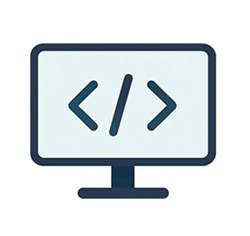
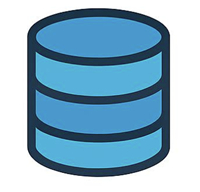
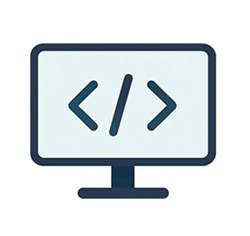
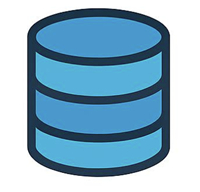
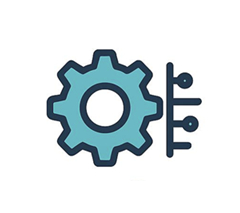
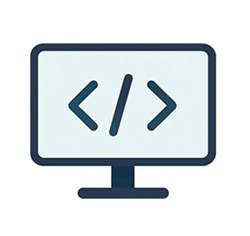
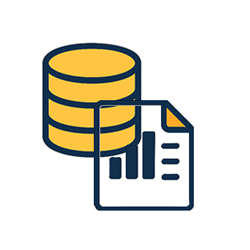
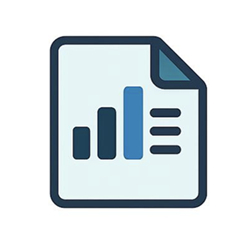
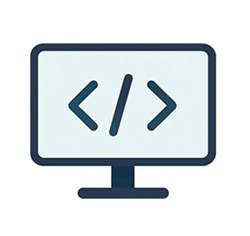
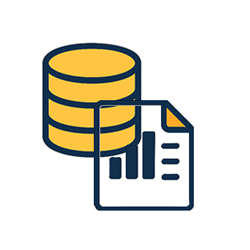
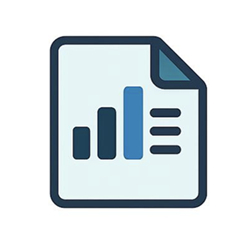
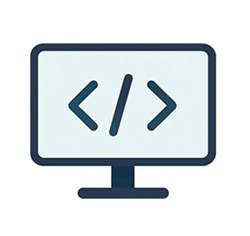
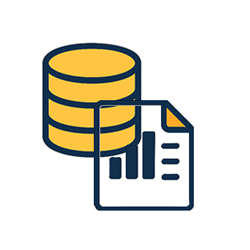
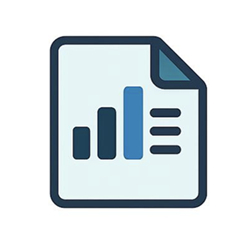
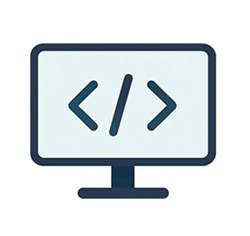
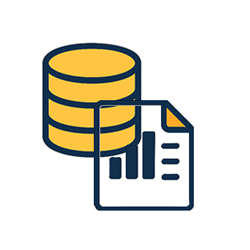
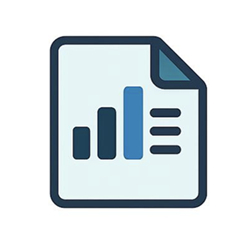

In [64]:
if assign_icons:
    # Dry run - Display pre and post icons based on specified workspace filters and workspace icon definition. Will NOT update any icons!
    display_workspace_icons(workspaces)
    sleep(2)

In [65]:
if assign_icons:
    for workspace in workspaces:
            set_workspace_icon(workspace.get('id'), workspace.get('icon_base64img'))

# Deploy Items

In [66]:
for environment in environments:
    print(f"\n--------------------------")
    print(f"Processing: {environment['environment_name']}")
    for workspace in [environment['workspaces']['code']]:
        exclude = []
        for it in item_deployment:

            new_id = None
            
            name = it["name"]
            type = it["type"]

            if name in exclude:
                continue
            deploy_item(workspace,workspace['name'],name,mapping_table,environment['environment_name'],connection_list, tasks, lakehouse_schema_enabled,None,it)
            
            for child in it.get("children",[]):
                child_name = child["name"]
                deploy_item(workspace,workspace['name'],name,mapping_table, environment['environment_name'],connection_list, tasks, lakehouse_schema_enabled,child_name,child) 

* Item updated
 ✅ Description applied to NB_FMD_PROCESSING_PARALLEL_MAIN.Notebook in 'DEMO CODE (D) FMD'
* 'NB_FMD_PROCESSING_PARALLEL_MAIN.Notebook' imported

#############################################
Deploying in DEMO CODE (D) FMD: NB_FMD_LOAD_BRONZE_SILVER.Notebook


* Item updated
 ✅ Description applied to NB_FMD_LOAD_BRONZE_SILVER.Notebook in 'DEMO CODE (D) FMD'
* 'NB_FMD_LOAD_BRONZE_SILVER.Notebook' imported

#############################################
Deploying in DEMO CODE (D) FMD: NB_FMD_LOAD_LANDING_BRONZE.Notebook


* Item updated
 ✅ Description applied to NB_FMD_LOAD_LANDING_BRONZE.Notebook in 'DEMO CODE (D) FMD'


* 'NB_FMD_LOAD_LANDING_BRONZE.Notebook' imported

#############################################
Deploying in DEMO CODE (D) FMD: PL_FMD_LDZ_COPY_FROM_ADLS_01.DataPipeline
Replacing connections guid in DEMO CODE (D) FMD: PL_FMD_LDZ_COPY_FROM_ADLS_01.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_SFTP_01.DataPipeline in 'DEMO CODE (D) FMD'
* 'PL_FMD_LDZ_COPY_FROM_SFTP_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (D) FMD: PL_FMD_LDZ_COPY_FROM_ONELAKE_FILES_01.DataPipeline
Replacing connections guid in DEMO CODE (D) FMD: PL_FMD_LDZ_COPY_FROM_ONELAKE_FILES_01.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_ONELAKE_FILES_01.DataPipeline in 'DEMO CODE (D) FMD'
* 'PL_FMD_LDZ_COPY_FROM_ONELAKE_FILES_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (D) FMD: PL_FMD_LDZ_COPY_FROM_ONELAKE_TABLES_01.DataPipeline
Replacing connections guid in DEMO CODE (D) FMD: PL_FMD_LDZ_COPY_FROM_ONELAKE_TABLES_01.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_ONELAKE_TABLES_01.DataPipeline in 'DEMO CODE (D) FMD'
* 'PL_FMD_LDZ_COPY_FROM_ONELAKE_TABLES_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (D) FMD: PL_FMD_LDZ_COMMAND_ADLS.DataPipeline
Replacing connections guid in DEMO CODE (D) FMD: PL_FMD_LDZ_COMMAND_ADLS.DataPipeline


! Modifying properties may lead to unintended consequences
Setting new property for 'PL_FMD_LDZ_COMMAND_ASQL.DataPipeline'...


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COMMAND_FTP.DataPipeline in 'DEMO CODE (D) FMD'
* 'PL_FMD_LDZ_COMMAND_FTP.DataPipeline' imported

#############################################
Deploying in DEMO CODE (D) FMD: PL_FMD_LDZ_COMMAND_SFTP.DataPipeline
Replacing connections guid in DEMO CODE (D) FMD: PL_FMD_LDZ_COMMAND_SFTP.DataPipeline


! Modifying properties may lead to unintended consequences
Setting new property for 'PL_FMD_LDZ_COMMAND_ADF.DataPipeline'...


* Item updated
 ✅ Description applied to PL_FMD_LOAD_SILVER.DataPipeline in 'DEMO CODE (D) FMD'
* 'PL_FMD_LOAD_SILVER.DataPipeline' imported

#############################################
Deploying in DEMO CODE (D) FMD: PL_TOOLING_POST_ASQL_TO_FMD.DataPipeline
Replacing connections guid in DEMO CODE (D) FMD: PL_TOOLING_POST_ASQL_TO_FMD.DataPipeline


! Modifying properties may lead to unintended consequences
Setting new property for 'PL_FMD_LOAD_LANDINGZONE.DataPipeline'...


* Item updated
 ✅ Description applied to PL_FMD_LOAD_LANDINGZONE.DataPipeline in 'DEMO CODE (D) FMD'
* 'PL_FMD_LOAD_LANDINGZONE.DataPipeline' imported

#############################################
Deploying in DEMO CODE (D) FMD: PL_FMD_LOAD_ALL.DataPipeline
Replacing connections guid in DEMO CODE (D) FMD: PL_FMD_LOAD_ALL.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LOAD_ALL.DataPipeline in 'DEMO CODE (D) FMD'
* 'PL_FMD_LOAD_ALL.DataPipeline' imported

#############################################
Deploying in DEMO CODE (D) FMD: VAR_FMD.VariableLibrary
Creating VariableLibrary: VAR_FMD.VariableLibrary


* 'VAR_FMD.VariableLibrary' imported

--------------------------
Processing: production

#############################################
Deploying in DEMO CODE (P) FMD: NB_FMD_PROCESSING_PARALLEL_MAIN.Notebook


* Item updated
 ✅ Description applied to NB_FMD_PROCESSING_PARALLEL_MAIN.Notebook in 'DEMO CODE (P) FMD'
* 'NB_FMD_PROCESSING_PARALLEL_MAIN.Notebook' imported

#############################################
Deploying in DEMO CODE (P) FMD: NB_FMD_LOAD_BRONZE_SILVER.Notebook


* Item updated
 ✅ Description applied to NB_FMD_LOAD_BRONZE_SILVER.Notebook in 'DEMO CODE (P) FMD'
* 'NB_FMD_LOAD_BRONZE_SILVER.Notebook' imported

#############################################
Deploying in DEMO CODE (P) FMD: NB_FMD_LOAD_LANDING_BRONZE.Notebook


! Modifying properties may lead to unintended consequences
Setting new property for 'PL_FMD_LDZ_COPY_FROM_ADLS_01.DataPipeline'...


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_ADLS_01.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COPY_FROM_ADLS_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_ADF.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_ADF.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_ADF.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COPY_FROM_ADF.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_ASQL_01.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_ASQL_01.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_ASQL_01.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COPY_FROM_ASQL_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_FTP_01.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_FTP_01.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_FTP_01.DataPipeline in 'DEMO CODE (P) FMD'


* 'PL_FMD_LDZ_COPY_FROM_FTP_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_SFTP_01.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_SFTP_01.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_SFTP_01.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COPY_FROM_SFTP_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_ONELAKE_FILES_01.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COPY_FROM_ONELAKE_FILES_01.DataPipeline


! Modifying properties may lead to unintended consequences
Setting new property for 'PL_FMD_LDZ_COPY_FROM_ONELAKE_TABLES_01.DataPipeline'...


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COPY_FROM_ONELAKE_TABLES_01.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COPY_FROM_ONELAKE_TABLES_01.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_ADLS.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_ADLS.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COMMAND_ADLS.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COMMAND_ADLS.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_ASQL.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_ASQL.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COMMAND_ASQL.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COMMAND_ASQL.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_FTP.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_FTP.DataPipeline


! Modifying properties may lead to unintended consequences
Setting new property for 'PL_FMD_LDZ_COMMAND_FTP.DataPipeline'...


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COMMAND_SFTP.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COMMAND_SFTP.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_ONELAKE.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COMMAND_ONELAKE.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COMMAND_ONELAKE.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_ADF.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LDZ_COMMAND_ADF.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LDZ_COMMAND_ADF.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LDZ_COMMAND_ADF.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LOAD_BRONZE.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LOAD_BRONZE.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LOAD_BRONZE.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LOAD_BRONZE.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LOAD_SILVER.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LOAD_SILVER.DataPipeline


! Modifying properties may lead to unintended consequences
Setting new property for 'PL_TOOLING_POST_ASQL_TO_FMD.DataPipeline'...


* Item updated
 ✅ Description applied to PL_TOOLING_POST_ASQL_TO_FMD.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_TOOLING_POST_ASQL_TO_FMD.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LOAD_LANDINGZONE.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LOAD_LANDINGZONE.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LOAD_LANDINGZONE.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LOAD_LANDINGZONE.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: PL_FMD_LOAD_ALL.DataPipeline
Replacing connections guid in DEMO CODE (P) FMD: PL_FMD_LOAD_ALL.DataPipeline


* Item updated
 ✅ Description applied to PL_FMD_LOAD_ALL.DataPipeline in 'DEMO CODE (P) FMD'
* 'PL_FMD_LOAD_ALL.DataPipeline' imported

#############################################
Deploying in DEMO CODE (P) FMD: VAR_FMD.VariableLibrary
Creating VariableLibrary: VAR_FMD.VariableLibrary


* 'VAR_FMD.VariableLibrary' imported


In [67]:
for workspace_gold in domain_deployment:
    for sub_domain_name in sub_domain_names:
        for workspace in [workspace_gold['workspaces']['code']]:
                exclude = []
                for it in item_deployment_code_sub_domain:

                    new_id = None
                    
                    name = it["name"]
                    type = it["type"]

                    if name in exclude:
                        continue
                        
                    # Only execute if workspace is 'gold'

                    deploy_item(workspace_gold,FrameworkName +' '+ sub_domain_name + ' CODE ('+ workspace_gold['environment_short']+') FMD', name,mapping_table, workspace_gold['environment_name'],connection_list, tasks, lakehouse_schema_enabled,None,it)


#############################################
Deploying in DEMO FINANCE CODE (D) FMD: NB_LOAD_GOLD.Notebook


* Item updated
 ✅ Description applied to NB_LOAD_GOLD.Notebook in 'DEMO FINANCE CODE (D) FMD'
* 'NB_LOAD_GOLD.Notebook' imported

#############################################
Deploying in DEMO FINANCE CODE (D) FMD: VAR_GOLD_FMD.VariableLibrary


Creating VariableLibrary: VAR_GOLD_FMD.VariableLibrary


* 'VAR_GOLD_FMD.VariableLibrary' imported

#############################################
Deploying in DEMO SALES CODE (D) FMD: NB_LOAD_GOLD.Notebook


* Item updated
 ✅ Description applied to NB_LOAD_GOLD.Notebook in 'DEMO SALES CODE (D) FMD'
* 'NB_LOAD_GOLD.Notebook' imported

#############################################
Deploying in DEMO SALES CODE (D) FMD: VAR_GOLD_FMD.VariableLibrary
Creating VariableLibrary: VAR_GOLD_FMD.VariableLibrary


* 'VAR_GOLD_FMD.VariableLibrary' imported

#############################################
Deploying in DEMO FINANCE CODE (P) FMD: NB_LOAD_GOLD.Notebook


* Item updated
 ✅ Description applied to NB_LOAD_GOLD.Notebook in 'DEMO FINANCE CODE (P) FMD'
* 'NB_LOAD_GOLD.Notebook' imported

#############################################
Deploying in DEMO FINANCE CODE (P) FMD: VAR_GOLD_FMD.VariableLibrary


Creating VariableLibrary: VAR_GOLD_FMD.VariableLibrary


* 'VAR_GOLD_FMD.VariableLibrary' imported

#############################################
Deploying in DEMO SALES CODE (P) FMD: NB_LOAD_GOLD.Notebook


* Item updated
 ✅ Description applied to NB_LOAD_GOLD.Notebook in 'DEMO SALES CODE (P) FMD'
* 'NB_LOAD_GOLD.Notebook' imported

#############################################
Deploying in DEMO SALES CODE (P) FMD: VAR_GOLD_FMD.VariableLibrary
Creating VariableLibrary: VAR_GOLD_FMD.VariableLibrary


* 'VAR_GOLD_FMD.VariableLibrary' imported


## Create SQL deployment Manifest

### Add Connection to Fabric Database

In [ ]:
custom_sql_deployment = {"queries_stored_procedures": []}
for connection in connections['value']:
    
    display_name = connection.get('displayName', '')
    if display_name and display_name.startswith('CON_FMD'):
        connection_type = connection.get('connectionDetails', {}).get('type', 'Unknown')
        connection_id = connection.get('id')
      
        exec_statement = (
            f"EXEC [integration].[sp_UpsertConnection] "
            f"@ConnectionGuid = \"{connection_id}\", "
            f"@Name = \"{display_name}\", "
            f"@Type = \"{connection_type}\", "
            f"@IsActive = 1"
        )
        custom_sql_deployment["queries_stored_procedures"].append(exec_statement)


### Add Workspaces to Fabric Database

In [ ]:
workspaces = []
workspaces.append(configuration['workspace'])

for environment in environments:
    workspaces.append(environment['workspaces']['code'])
    workspaces.append(environment['workspaces']['data'])

    
for workspace in workspaces:
    print(f'EXEC [integration].[sp_UpsertWorkspace](@WorkspaceId = "{workspace["id"]}" ,@Name = "{workspace["name"]}")')
    custom_sql_deployment["queries_stored_procedures"].append(f'EXEC [integration].[sp_UpsertWorkspace] @WorkspaceId = "{workspace["id"]}", @Name = "{workspace["name"]}"')

EXEC [integration].[sp_UpsertWorkspace](@WorkspaceId = "833011b5-81ea-4841-ad1d-1ac06b0cec2e" ,@Name = "DEMO CONFIG FMD")
EXEC [integration].[sp_UpsertWorkspace](@WorkspaceId = "911f2113-35ee-4e2c-8dca-d29a3da35385" ,@Name = "DEMO CODE (D) FMD")
EXEC [integration].[sp_UpsertWorkspace](@WorkspaceId = "4748a8df-381f-4b36-9ec7-cb83cfec435e" ,@Name = "DEMO DATA (D) FMD")
EXEC [integration].[sp_UpsertWorkspace](@WorkspaceId = "da3cf3d6-5633-4022-9c5e-615377ccc43e" ,@Name = "DEMO CODE (P) FMD")
EXEC [integration].[sp_UpsertWorkspace](@WorkspaceId = "b08e655e-eaa0-470d-9b8c-5397dfc52389" ,@Name = "DEMO DATA (P) FMD")


### Add Data Pipelines to Fabric Database

In [ ]:
for environment in environments:
    result = run_fab_command(f"api -X get workspaces/{environment['workspaces']['code']['id']}/items", capture_output=True, silently_continue=True)
    existing_items = json.loads(result)['text']
    for item in existing_items.get('value', []):
        if item['type'] == 'DataPipeline':
            print(f'EXEC [integration].[sp_UpsertPipeline] @PipelineId = "{item["id"]}", @WorkspaceId = "{environment["workspaces"]["code"]["id"]}" ,@Name = "{item["displayName"]}"')
            custom_sql_deployment["queries_stored_procedures"].append(f'EXEC [integration].[sp_UpsertPipeline] @PipelineId = "{item["id"]}", @WorkspaceId = "{environment["workspaces"]["data"]["id"]}" ,@Name = "{item["displayName"]}"')

EXEC [integration].[sp_UpsertPipeline] @PipelineId = "c4b0fb33-9a4e-4328-8a0e-74e880f1967b", @WorkspaceId = "911f2113-35ee-4e2c-8dca-d29a3da35385" ,@Name = "PL_FMD_LDZ_COPY_FROM_ADLS_01"
EXEC [integration].[sp_UpsertPipeline] @PipelineId = "17482299-3775-4bc6-8285-f7ef6aa1da61", @WorkspaceId = "911f2113-35ee-4e2c-8dca-d29a3da35385" ,@Name = "PL_FMD_LDZ_COPY_FROM_ADF"
EXEC [integration].[sp_UpsertPipeline] @PipelineId = "beace0b9-a39a-4417-9575-9212b4418f8a", @WorkspaceId = "911f2113-35ee-4e2c-8dca-d29a3da35385" ,@Name = "PL_FMD_LDZ_COPY_FROM_ASQL_01"
EXEC [integration].[sp_UpsertPipeline] @PipelineId = "1b282a00-dfe7-4e97-a1db-a96baf9a4049", @WorkspaceId = "911f2113-35ee-4e2c-8dca-d29a3da35385" ,@Name = "PL_FMD_LDZ_COPY_FROM_FTP_01"
EXEC [integration].[sp_UpsertPipeline] @PipelineId = "9e558415-0ffd-4ba7-9139-5c8b9c8d845d", @WorkspaceId = "911f2113-35ee-4e2c-8dca-d29a3da35385" ,@Name = "PL_FMD_LDZ_COPY_FROM_SFTP_01"
EXEC [integration].[sp_UpsertPipeline] @PipelineId = "7ff11345-4b33-46

### Add Lakehouses to Fabric Database

In [ ]:
for environment in environments:
    result = run_fab_command(f"api -X get workspaces/{environment['workspaces']['data']['id']}/items", capture_output=True, silently_continue=True)
    existing_items = json.loads(result)['text']
    for item in existing_items.get('value', []):
        if item['type'] == 'Lakehouse':
            print(f'EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "{item["id"]}", @WorkspaceId = "{environment["workspaces"]["data"]["id"]}" ,@Name = "{item["displayName"]}"')
            custom_sql_deployment["queries_stored_procedures"].append(f'EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "{item["id"]}", @WorkspaceId = "{environment["workspaces"]["data"]["id"]}" ,@Name = "{item["displayName"]}"')

EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "3d092bb5-0a62-4ba3-9262-98ec8a65c23f", @WorkspaceId = "4748a8df-381f-4b36-9ec7-cb83cfec435e" ,@Name = "LH_DATA_LANDINGZONE"
EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "a2e97dc1-6470-4382-9c6c-45026e2c6430", @WorkspaceId = "4748a8df-381f-4b36-9ec7-cb83cfec435e" ,@Name = "LH_BRONZE_LAYER"
EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "a025cb3b-1c89-4d2b-8f29-d7c9a0b332fe", @WorkspaceId = "4748a8df-381f-4b36-9ec7-cb83cfec435e" ,@Name = "LH_SILVER_LAYER"
EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "dba92875-de6a-46af-a286-e01093d80612", @WorkspaceId = "b08e655e-eaa0-470d-9b8c-5397dfc52389" ,@Name = "LH_DATA_LANDINGZONE"
EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "b5411027-733e-4f90-aa5e-cdd72f7d7eff", @WorkspaceId = "b08e655e-eaa0-470d-9b8c-5397dfc52389" ,@Name = "LH_BRONZE_LAYER"
EXEC [integration].[sp_UpsertLakehouse] @LakehouseId = "5c3ff48b-3f1c-4626-817e-2a7bd400e91d", @WorkspaceId = "b

### Add Demo data for testing to Fabric Database

In [ ]:
if load_demo_data:  
    demo_sql_deployment = {"queries_stored_procedures": []}
    demo_sql_deployment["queries_stored_procedures"].append(f'EXEC [integration].[sp_UpsertConnection] @ConnectionGuid = "00000000-0000-0000-0000-000000000000", @Name = "CON_FMD_ONELAKE", @Type = "ONELAKE", @IsActive = 1')
    demo_sql_deployment["queries_stored_procedures"].append("""
        DECLARE @DataSourceIdInternal INT = (SELECT DataSourceId FROM integration.DataSource WHERE Name = 'LH_DATA_LANDINGZONE' and Type='ONELAKE_TABLES_01')
        DECLARE @ConnectionIdInternal INT = (SELECT ConnectionId FROM integration.Connection WHERE ConnectionGuid = '00000000-0000-0000-0000-000000000000')
        EXECUTE [integration].[sp_UpsertDataSource] 
            @ConnectionId = @ConnectionIdInternal
            ,@DataSourceId = @DataSourceIdInternal
            ,@Name = 'LH_DATA_LANDINGZONE'
            ,@Namespace = 'ONELAKE'
            ,@Type = 'ONELAKE_TABLES_01'
            ,@Description = 'ONELAKE_TABLES'
            ,@IsActive = 1
    """)
    demo_sql_deployment["queries_stored_procedures"].append("""
        DECLARE @DataSourceIdInternal INT = (SELECT DataSourceId FROM integration.DataSource WHERE Name = 'LH_DATA_LANDINGZONE' and Type ='ONELAKE_FILES_01')
        DECLARE @ConnectionIdInternal INT = (SELECT ConnectionId FROM integration.Connection WHERE ConnectionGuid = '00000000-0000-0000-0000-000000000000')
        EXECUTE [integration].[sp_UpsertDataSource] 
            @ConnectionId = @ConnectionIdInternal
            ,@DataSourceId = @DataSourceIdInternal
            ,@Name = 'LH_DATA_LANDINGZONE'
            ,@Namespace = 'ONELAKE'
            ,@Type = 'ONELAKE_FILES_01'
            ,@Description = 'ONELAKE_FILES'
            ,@IsActive = 1
    """)
    demo_sql_deployment["queries_stored_procedures"].append("""
        DECLARE @LandingzoneEntityIdInternal INT = (SELECT LandingzoneEntityId FROM integration.LandingzoneEntity WHERE SourceSchema = 'in' and SourceName = 'customer')
        DECLARE @DataSourceIdInternal INT = (SELECT DataSourceId FROM integration.DataSource WHERE Name = 'LH_DATA_LANDINGZONE' and Type='ONELAKE_TABLES_01')
        DECLARE @LakehouseIdInternal INT = (SELECT top 1 LakehouseId FROM integration.Lakehouse WHERE Name = 'LH_DATA_LANDINGZONE')
        EXECUTE [integration].[sp_UpsertLandingzoneEntity] 
            @LandingzoneEntityId = @LandingzoneEntityIdInternal
            ,@DataSourceId = @DataSourceIdInternal
            ,@LakehouseId = @LakehouseIdInternal
            ,@SourceSchema = 'in'
            ,@SourceName = 'customer'
            ,@SourceCustomSelect = ''
            ,@FileName = 'customer'
            ,@FilePath = 'fmd'
            ,@FileType = 'parquet'
            ,@IsIncremental = 0
            ,@IsIncrementalColumn = ''
            ,@IsActive = 1
    """)
    demo_sql_deployment["queries_stored_procedures"].append("""
        DECLARE @LandingzoneEntityIdInternal INT = (SELECT LandingzoneEntityId FROM integration.LandingzoneEntity WHERE SourceSchema = 'in' and SourceName = 'customer')
        DECLARE @BronzeLayerEntityIdInternal INT = (SELECT BronzeLayerEntityId FROM integration.BronzeLayerEntity WHERE [Schema] = 'in' and [Name] = 'customer')
        DECLARE @LakehouseIdInternal INT = (SELECT top 1 LakehouseId FROM integration.Lakehouse WHERE Name = 'LH_BRONZE_LAYER')
        EXECUTE [integration].[sp_UpsertBronzeLayerEntity] 
            @BronzeLayerEntityId = @BronzeLayerEntityIdInternal
            ,@LandingzoneEntityId = @LandingzoneEntityIdInternal
            ,@Schema = 'in'
            ,@Name = 'customer'
            ,@FileType = 'Delta'
            ,@LakehouseId = @LakehouseIdInternal
            ,@PrimaryKeys = 'CustomerId'
            ,@IsActive = 1
    """)
    demo_sql_deployment["queries_stored_procedures"].append("""
        DECLARE @BronzeLayerEntityIdInternal INT = (SELECT BronzeLayerEntityId FROM integration.BronzeLayerEntity WHERE [Schema] = 'in' and [Name] = 'customer')
        DECLARE @SilverLayerEntityIdInternal INT = (SELECT SilverLayerEntityId FROM integration.SilverLayerEntity WHERE [Schema] = 'in' and [Name] = 'customer')
        DECLARE @LakehouseIdInternal INT = (SELECT top 1 LakehouseId FROM integration.Lakehouse WHERE Name = 'LH_SILVER_LAYER')
        EXECUTE [integration].[sp_UpsertSilverLayerEntity] 
            @SilverLayerEntityId = @SilverLayerEntityIdInternal
            ,@BronzeLayerEntityId = @BronzeLayerEntityIdInternal
            ,@LakehouseId = @LakehouseIdInternal
            ,@Name = 'customer'
            ,@Schema = 'in'
            ,@FileType = 'delta'
            ,@IsActive = 1
    """)

## Deploy SQL Code

In [ ]:
for target_item in data_deployment:
    if isinstance(target_item, dict) and target_item.get('type') == 'SQLDatabase':
        connstring = target_item.get("connectionString")
        database = target_item.get('databaseName')

try:
    i = 0

    token = notebookutils.credentials.getToken('pbi').encode('utf-16-le')
    token_struct = struct.pack(f'<I{len(token)}s', len(token), token)

    print(f"DRIVER={driver};SERVER={connstring};PORT=1433;DATABASE={database};")
    connection = pyodbc.connect(f"DRIVER={driver};SERVER={connstring};PORT=1433;DATABASE={database};", attrs_before={1256:token_struct}, timeout=12)

    with connection.cursor() as cursor:
        cursor.execute("SELECT 1")  # Execute the warm-up query (a simple query like 'SELECT 1' can be used)
        cursor.fetchone()
        connection.timeout = 10  # Setting a lower timeout for subsequent queries
    for it in sql_deployment:
        for i, query in enumerate(it["queries_schemas"]):
            print(f' - execute "{query}"')
            cursor.execute(query)
            cursor.commit()
        for i, query in enumerate(it["queries_tables"]):
            print(f' - execute "{query}"')
            cursor.execute(query)
            cursor.commit()
        for i, query in enumerate(it["queries_views"]):
            print(f' - execute "{query}"')
            cursor.execute(query)
            cursor.commit()
        for i, query in enumerate(it["queries_stored_procedures"]):
            print(f' - execute "{query}"')
            cursor.execute(query)
            cursor.commit()
        for i, query in enumerate(it["queries_logging"]):
            print(f' - execute "{query}"')
            cursor.execute(query)
            cursor.commit()
        for i, query in enumerate(custom_sql_deployment["queries_stored_procedures"]):
            print(f' - execute "{query}"')
            cursor.execute(query)
            cursor.commit()
        for i, query in enumerate(demo_sql_deployment["queries_stored_procedures"]):
            print(f' - execute "{query}"')
            cursor.execute(query)
            cursor.commit()

    tasks.append({"task_name":f"{workspace.get('displayName')} {database} query {i}", "task_duration": 1, "status": f"success"})
except pyodbc.OperationalError as e:
    print(e) 
    tasks.append({"task_name":f"{workspace.get('displayName')} {database} query {i}", "task_duration": 1, "status": f"pyodbc failed: {e}"})
except Exception as e:
    print(e) 
    tasks.append({"task_name":f"{workspace.get('displayName')} {database} query {i}", "task_duration": 1, "status": f"failed: {e}"})

DRIVER={ODBC Driver 18 for SQL Server};SERVER=nl7yhqnbrscude3yv6mas6bxpq-wuitba7kqfaurli5dlagwdhmfy.database.fabric.microsoft.com;PORT=1433;DATABASE=SQL_DEMO_FRAMEWORK-17bc0448-0eec-47b4-be48-67aac522bb3f;
 - execute "
    IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'logging')
    BEGIN
        EXEC('CREATE SCHEMA [logging];');
    END
    "
 - execute "
    IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'execution')
    BEGIN
        EXEC('CREATE SCHEMA [execution];');
    END
    "
 - execute "
    IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'integration')
    BEGIN
        EXEC('CREATE SCHEMA [integration];');
    END
    "
 - execute "
    DECLARE @SQL NVARCHAR(MAX) = '';

    SELECT @SQL = @SQL + 'ALTER TABLE ' + QUOTENAME(s.name) + '.' + QUOTENAME(t.name) + 
    ' DROP CONSTRAINT ' + QUOTENAME(dc.name) + ';' + CHAR(13)
    FROM sys.default_constraints dc
    INNER JOIN sys.tables t ON dc.parent_object_id = t.object_id
    INNER JOIN sys.schemas s ON t.s

In [ ]:
display(tasks)